In [113]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import SGDClassifier, LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_predict
from sklearn.preprocessing import OneHotEncoder, RobustScaler, MinMaxScaler, StandardScaler
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix, f1_score, precision_score, recall_score, accuracy_score, precision_recall_curve, roc_curve, roc_auc_score
import numpy as np

In [114]:
incomes = pd.read_csv('income_evaluation.csv')
incomes.head()
incomes.rename(columns= lambda x: x.strip(), inplace=True)

In [115]:
incomes.describe().applymap(lambda x: f"{x:0.1f}")

C:\Users\asosz\AppData\Local\Temp\ipykernel_17364\418962863.py:1: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  incomes.describe().applymap(lambda x: f"{x:0.1f}")


,age,fnlwgt,education-num,capital-gain,capital-loss,hours-per-week
count,32561.0,32561.0,32561.0,32561.0,32561.0,32561.0
mean,38.6,189778.4,10.1,1077.6,87.3,40.4
std,13.6,105550.0,2.6,7385.3,403.0,12.3
min,17.0,12285.0,1.0,0.0,0.0,1.0
25%,28.0,117827.0,9.0,0.0,0.0,40.0
50%,37.0,178356.0,10.0,0.0,0.0,40.0
75%,48.0,237051.0,12.0,0.0,0.0,45.0
max,90.0,1484705.0,16.0,99999.0,4356.0,99.0


In [116]:
incomes.columns

Index(['age', 'workclass', 'fnlwgt', 'education', 'education-num',
       'marital-status', 'occupation', 'relationship', 'race', 'sex',
       'capital-gain', 'capital-loss', 'hours-per-week', 'native-country',
       'income'],
      dtype='object')

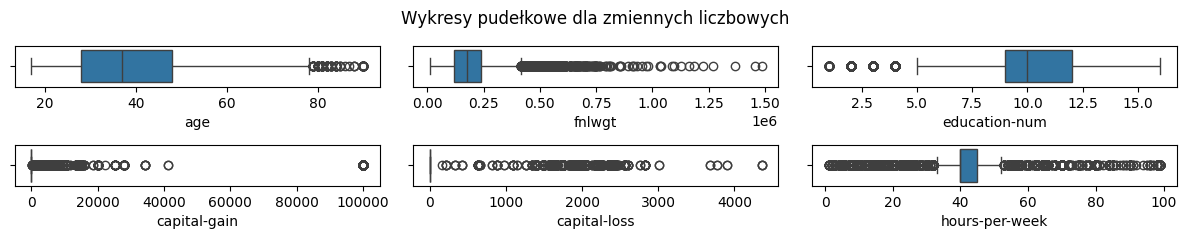

In [117]:
numeric_cols = ['age', 'fnlwgt', 'education-num', 'capital-gain', 'capital-loss', 'hours-per-week']

plt.figure(figsize=(12, 6))

for i, column in enumerate(numeric_cols, 1):
    plt.subplot(len(numeric_cols), len(numeric_cols)//2, i)
    sns.boxplot(x=incomes[column])

plt.suptitle('Wykresy pudełkowe dla zmiennych liczbowych')
plt.tight_layout()
plt.show()

In [118]:
null_counts = pd.DataFrame(incomes[incomes.select_dtypes('number').columns].isna().sum(), columns=['Null Counts'])
null_counts

# plt.bar(null_counts.index, null_counts['Null Counts'], color='dimgray')
# plt.xticks(rotation=45, ha='right')
# plt.xlabel('Columns')
# plt.ylabel('Brakujące wartości')
# plt.title('Brakujące wartości w zbiorze danych')
# for i, value in enumerate(null_counts['Null Counts']):
#     plt.text(i, value + 1, str(value), ha='center', va='bottom', fontsize=10)
# plt.show()

,Null Counts
age,0
fnlwgt,0
education-num,0
capital-gain,0
capital-loss,0
hours-per-week,0


In [119]:
incomes = incomes.rename(columns=lambda x: x.strip())
categories = ['workclass', 'education', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'native-country', 'income']
incomes[categories] = incomes[categories].astype("category")
incomes = incomes.applymap(lambda x: x.strip() if not isinstance(x, int) else x)

C:\Users\asosz\AppData\Local\Temp\ipykernel_17364\1308178635.py:4: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  incomes = incomes.applymap(lambda x: x.strip() if not isinstance(x, int) else x)


In [120]:
for column in categories:
    print(column, set(incomes[column]))

workclass {'Federal-gov', 'Self-emp-not-inc', 'Without-pay', 'State-gov', 'Local-gov', 'Self-emp-inc', 'Never-worked', 'Private', '?'}
education {'Bachelors', '12th', 'Masters', 'HS-grad', '7th-8th', 'Doctorate', 'Assoc-acdm', '10th', '1st-4th', 'Preschool', '11th', 'Prof-school', 'Some-college', '5th-6th', 'Assoc-voc', '9th'}
marital-status {'Separated', 'Married-AF-spouse', 'Divorced', 'Married-spouse-absent', 'Widowed', 'Married-civ-spouse', 'Never-married'}
occupation {'Tech-support', 'Protective-serv', 'Prof-specialty', 'Handlers-cleaners', 'Sales', 'Craft-repair', 'Farming-fishing', 'Machine-op-inspct', '?', 'Armed-Forces', 'Transport-moving', 'Adm-clerical', 'Other-service', 'Exec-managerial', 'Priv-house-serv'}
relationship {'Own-child', 'Not-in-family', 'Husband', 'Other-relative', 'Wife', 'Unmarried'}
race {'Amer-Indian-Eskimo', 'White', 'Asian-Pac-Islander', 'Other', 'Black'}
sex {'Female', 'Male'}
native-country {'South', 'Ecuador', 'El-Salvador', 'England', 'Puerto-Rico', 

In [121]:
for column in ['workclass', 'occupation', 'native-country']:
    incomes[column].replace("?", np.NaN, inplace=True)
    incomes[column] = incomes[column].fillna(incomes[column].mode()[0])

C:\Users\asosz\AppData\Local\Temp\ipykernel_17364\2606609191.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  incomes[column].replace("?", np.NaN, inplace=True)
C:\Users\asosz\AppData\Local\Temp\ipykernel_17364\2606609191.py:2: FutureWarning: The behavior of Series.replace (and DataFrame.replace) with CategoricalDtype is deprecated. In a future version, replace will only be used for cases that preserve the categories. To change the categories, use ser.cat.rename_categories instead.
  incomes[column].replace("?", np.NaN, inp

In [122]:
incomes['additional_money'] = incomes['capital-gain'] - incomes['capital-loss']
incomes = incomes.drop(columns=['capital-gain', 'capital-loss', 'education-num', 'relationship'], axis=1)
incomes.head()

,age,workclass,fnlwgt,education,marital-status,occupation,race,sex,hours-per-week,native-country,income,additional_money
0,39,State-gov,77516,Bachelors,Never-married,Adm-clerical,White,Male,40,United-States,<=50K,2174
1,50,Self-emp-not-inc,83311,Bachelors,Married-civ-spouse,Exec-managerial,White,Male,13,United-States,<=50K,0
2,38,Private,215646,HS-grad,Divorced,Handlers-cleaners,White,Male,40,United-States,<=50K,0
3,53,Private,234721,11th,Married-civ-spouse,Handlers-cleaners,Black,Male,40,United-States,<=50K,0
4,28,Private,338409,Bachelors,Married-civ-spouse,Prof-specialty,Black,Female,40,Cuba,<=50K,0


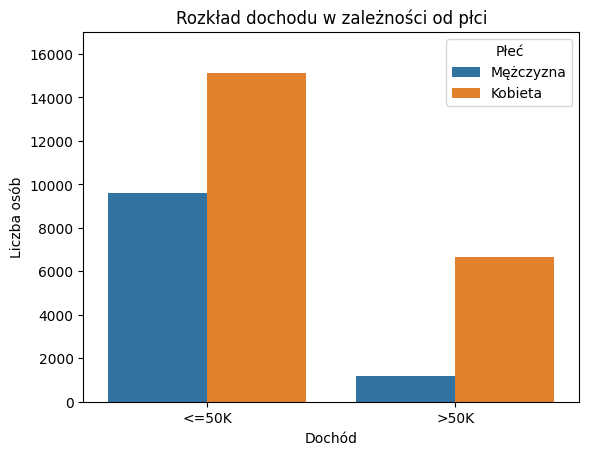

In [123]:
ctplot = sns.countplot(data=incomes, x='income', hue='sex')

ctplot.set_xlabel('Dochód')
ctplot.set_ylabel('Liczba osób')
ctplot.set_title('Rozkład dochodu w zależności od płci')
ctplot.set_ylim(0, 17000)

ctplot.legend(title='Płeć', labels=['Mężczyzna', 'Kobieta'])

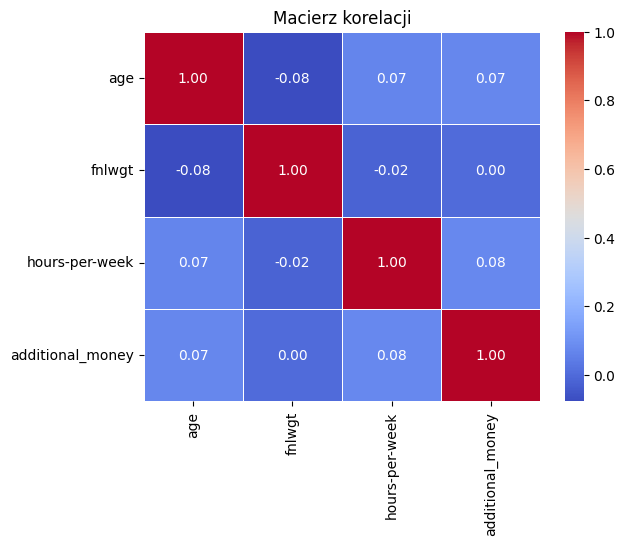

In [124]:
def adjust_income(income: str):
  if income == '<=50K':
    return 0
  elif income == '>50K':
    return 1
  else:
      return 0

incomes['income_adj'] = incomes['income'].apply(adjust_income)
numeric_cols = incomes.select_dtypes('number').columns
correlation_matrix = incomes[numeric_cols].corr()
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f", linewidths=.5)
plt.title('Macierz korelacji')
incomes.drop('income_adj', axis=1, inplace=True)

In [125]:
def change_education(education: str):
    if education in ["10th", "11th", "12th", "1st-4th", "5th-6th", "7th-8th", "9th", "Preschool"]:
        return "Primary"
    elif education in ["Bachelors", "Some-college"]:
        return "Bachelors"
    elif education in ["Assoc-acdm", "Assoc-voc"]:
        return "Associate"
    else:
        return education
incomes['education'] = incomes['education'].apply(change_education)
set(incomes['education'])

{'Associate',
 'Bachelors',
 'Doctorate',
 'HS-grad',
 'Masters',
 'Primary',
 'Prof-school'}

In [126]:
training_cols = ['age', 'workclass', 'education', 'race', 'sex', 'hours-per-week', 'native-country', 'additional_money', 'income', 'fnlwgt']
training_incomes = incomes[training_cols]
categorical_cols = ['workclass', 'race', 'sex', 'native-country', 'education']
numeric = ['age', 'hours-per-week', 'additional_money', 'fnlwgt']

encoder = OneHotEncoder(sparse_output=False)
encoded_cols = pd.DataFrame(encoder.fit_transform(training_incomes[categorical_cols]), columns=encoder.get_feature_names_out(categorical_cols))
training_incomes = pd.concat([training_incomes.drop(columns=categorical_cols), encoded_cols], axis=1)

scaler = RobustScaler()
# scaler = StandardScaler()
# scaler = MinMaxScaler()

training_incomes[numeric] = scaler.fit_transform(training_incomes[numeric])

training_incomes.columns
X = training_incomes.drop('income', axis=1)
y = incomes['income']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)


In [127]:
rand_for = RandomForestClassifier(n_estimators=500, random_state=42, max_leaf_nodes=160)

rand_for.fit(X_train, y_train)
rand_for.score(X_test, y_test)

0.841911313106498

C:\Users\asosz\AppData\Local\Temp\ipykernel_17364\2769294560.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature', data=feature_importance_df, palette='viridis')


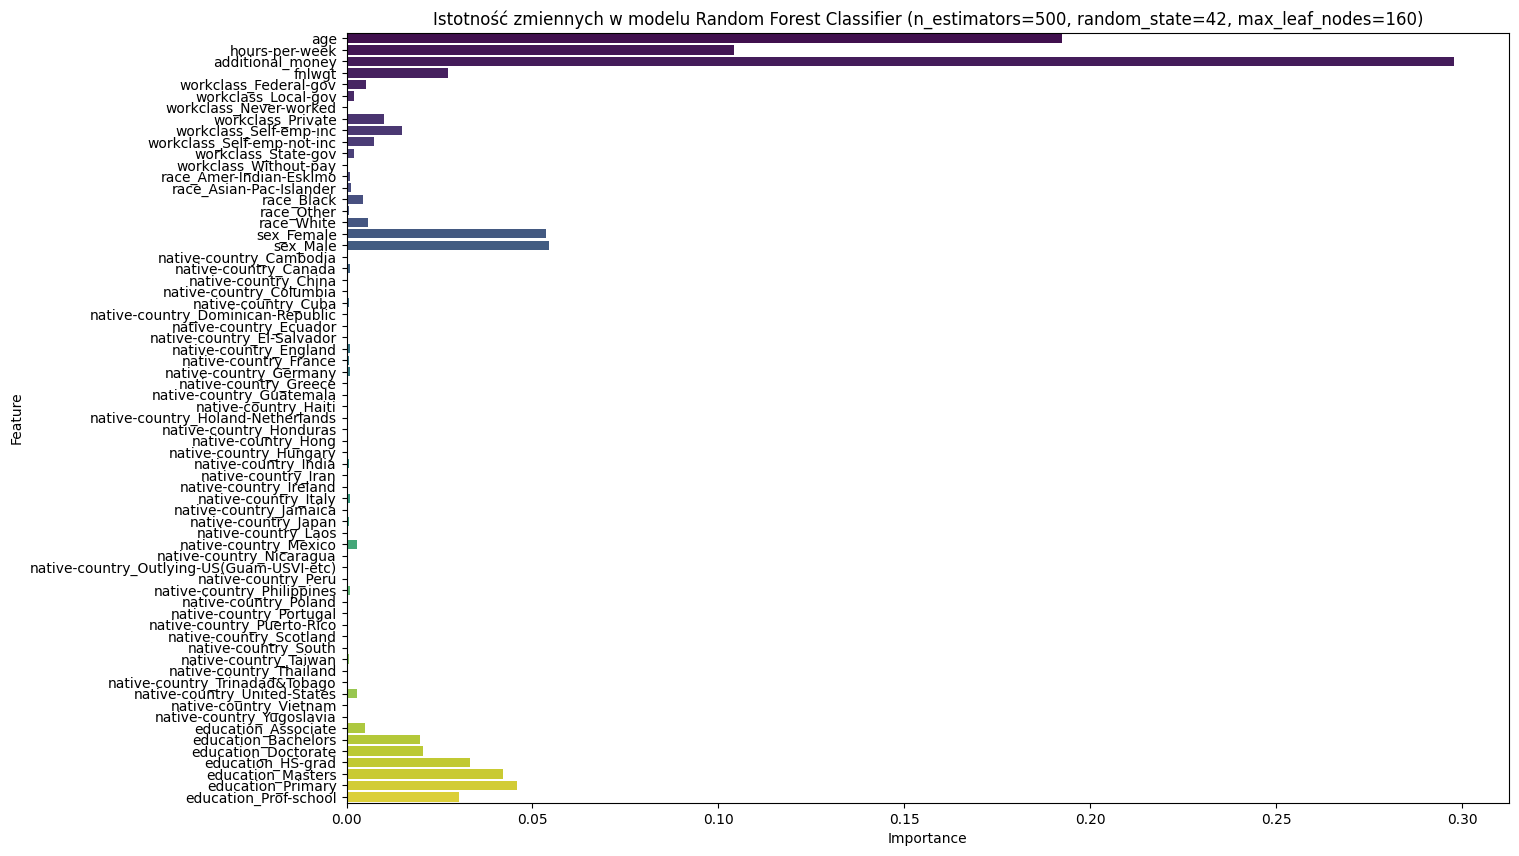

In [128]:
feature_importances = rand_for.feature_importances_

# Create a DataFrame to display feature importances
feature_importance_df = pd.DataFrame({'Feature': X.columns, 'Importance': feature_importances})
feature_importance_df.sort_values("Importance", ascending=False)
feature_importance_df['Importance'].map(lambda x: f"{x:0.1f}")

# Plot the feature importances
plt.figure(figsize=(15, 10))
sns.barplot(x='Importance', y='Feature', data=feature_importance_df, palette='viridis')
plt.title('Istotność zmiennych w modelu Random Forest Classifier (n_estimators=500, random_state=42, max_leaf_nodes=160)')
plt.show()

In [129]:
y_pred = rand_for.predict(X_test)
cm = confusion_matrix(y_test, y_pred)
cm

array([[6012,  202],
       [1085,  842]], dtype=int64)

In [130]:
precision_score(y_test, y_pred, pos_label="<=50K")
recall_score(y_test, y_pred, average="binary", pos_label="<=50K")
f1_score(y_test, y_pred, pos_label="<=50K")

In [137]:
y_pred_proba = rand_for.predict_proba(X_test)[:, 1]
y_pred_proba
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba, pos_label=">50K")
roc_auc = roc_auc_score(y_test, y_pred_proba)


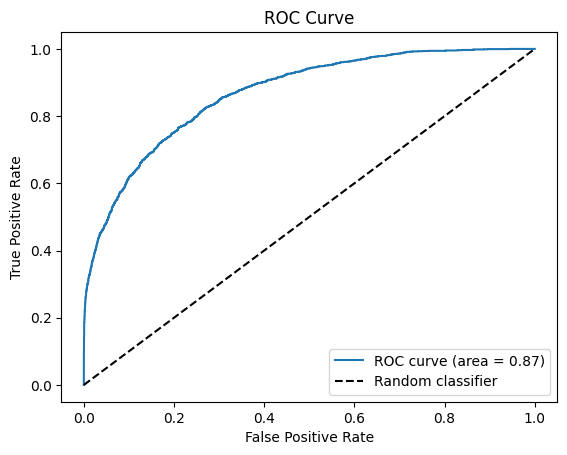

In [138]:

# Plot the ROC curve 
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc) 
# roc curve for tpr = fpr  
plt.plot([0, 1], [0, 1], 'k--', label='Random classifier') 
plt.xlabel('False Positive Rate') 
plt.ylabel('True Positive Rate') 
plt.title('ROC Curve') 
plt.legend(loc="lower right") 
plt.show()


In [140]:
y_probas_forest = cross_val_predict(rand_for, X_train, y_train, cv=3,
                                    method="predict_proba")
y_scores_forest = y_probas_forest[:, 1]
precisions_forest, recalls_forest, thresholds_forest = precision_recall_curve(
    y_train, y_scores_forest)

ValueError: y_true takes value in {'<=50K', '>50K'} and pos_label is not specified: either make y_true take value in {0, 1} or {-1, 1} or pass pos_label explicitly.